In [1]:
import numpy as np
import math
# for timing operations
import timeit
# for graphs
import matplotlib.pyplot as plt
# for infinite sums/integrals and floats
import mpmath
# for saving photos
import time

In [2]:
# the first test in our paper
Q = 53
n = 2
gamma = 2
beta = 0.3
# a sigma value used formerly that gives approximately the same value for beta
# sigma = 6
# beta = sigma/Q*math.sqrt(2*math.pi)
M = 801

# # Test in [4]
# beta = 0.01
# Q = 331
# n = 9
# gamma = 31
# M = 6001

# # x^5-6x+2, the other test in our paper
# beta = 0.02
# Q = 101
# n = 5
# gamma = 20
# M = 2401

In [3]:
factorials = np.zeros(M,dtype=object)
for i in range(Q):
    if i==0:
        factorials[i] = 1
    else:
         factorials[i] = (i+1)*factorials[i-1]

In [4]:
factorials = factorials.astype(np.longdouble)

A recursive formula in $m$ -- Uniform case

In [5]:
Pprev = np.zeros(M,dtype=np.longdouble)
Pcurr = np.zeros(M,dtype=np.longdouble)

for q in range(1, Q+1):
    for m in range(M):
        if m<q:
            Pcurr[m] = np.longdouble(0)
        elif q==1: # (and m>0 of course)
            Pcurr[m] = np.longdouble(1)
        elif m==q:
            Pcurr[m] = factorials[q-1]*(1/q**q)
        else:
            Pcurr[m] = Pcurr[m-1]+Pprev[m-1]*((q-1)/q)**(m-1)
#     if q==2:
#         print(Pcurr)
    Pprev = Pcurr.copy()

Generating mapped distribution

In [6]:
G = np.zeros(Q,dtype=np.longdouble)

def psi(beta,x):
    return mpmath.nsum(lambda k: (1/beta)*mpmath.exp(-mpmath.pi*((x-k)/beta)**2), [-mpmath.inf, mpmath.inf])

for i in range(0, Q):
    G[i] = mpmath.quad(lambda x: psi(beta, x), [(i-1/2)/Q, (i+1/2)/Q])

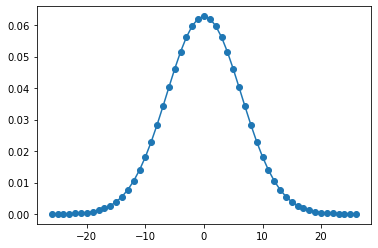

In [7]:
plt.plot(range(-(Q//2),1+Q//2),np.roll(G,Q//2))
plt.scatter(range(-(Q//2),1+Q//2),np.roll(G,Q//2))
plt.savefig(time.strftime("%Y-%m-%d_%H:%M:%S_")+'original-dist.png', facecolor='w', transparent=False)

In [8]:
# const last
# put leading coefficient first in array
A = [gamma**k%Q for k in range(1,n)]

c = np.flip(G)
t = c
for i in range(0, n-1):
    temp = np.zeros((Q-1)*A[i]+1,dtype=np.longdouble)
    temp[0:-1:A[i]] = c[0:-1]
    temp[-1] = c[-1]
    
    modpoly = np.zeros(Q+1,dtype=np.longdouble)
    modpoly[0] = 1
    modpoly[-1] = -1
    
    t = np.convolve(t, temp)
    t = np.polydiv(t,modpoly)[1]
t = np.flip(t)

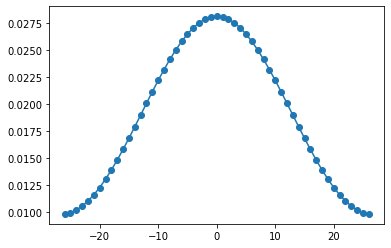

In [9]:
plt.plot(range(-(Q//2),1+Q//2),np.roll(t,Q//2))
plt.scatter(range(-(Q//2),1+Q//2),np.roll(t,Q//2))
plt.savefig(time.strftime("%Y-%m-%d_%H:%M:%S_")+'mapped-dist.png', facecolor='w', transparent=False)

Recursive formula for non-uniform case

In [10]:
prods = np.zeros(Q,dtype=np.longdouble)
ps = np.zeros(Q,dtype=np.longdouble)

for i in range(Q):
    temp = t[0:i+1]/sum(t[0:i+1])
    prods[i] = np.prod(temp)
    ps[i] = temp[-1]

One could make this more memory-efficient by having the longdouble matrix fill up as only maintaining two rows of the Sierpinski triangle at a time.

In [11]:
combs = np.zeros((M,M+1),dtype=object)
combs[0,0] = 1
for i in range(1,M):
    for j in range(M+1):
        combs[i,j] = combs[i-1,j-1]+combs[i-1,j]

In [12]:
# This step takes a long time.
combs = combs.astype(np.longdouble)

In [13]:
# first axis is how many elts are remaining +1, so idx 0 is 1 elt remaining (Q=1) and idx Q-1 is all Q elts in
# Q = 10 means idx 0 is 1, idx 9 is 10
# M = 2 means idx 0 is 0 and idx 1 is 1

# for O(M*Q), longdouble mode
R = np.zeros((M,Q),dtype=np.longdouble)

# for O(M+Q), longdouble mode
# Rprev = np.zeros(M,dtype=np.longdouble)
# Rcurr = np.zeros(M,dtype=np.longdouble)
    
times = []
start_time = timeit.default_timer()

# q and m are the actual values, so for indexing P we need idx changes
for m in range(M):
    for q in range(1, Q+1):
# begin O(M*Q) mode code
        if m<q:
            R[m,q-1] = np.longdouble(0)
        elif q==1: # (and m>0 of course)
            R[m,q-1] =  np.longdouble(1)
        elif m==q:
            R[m,q-1] = factorials[q-1]*prods[q-1]
        else:
            for k in range(1,m-q+2):
                R[m,q-1] += combs[m,k]*ps[q-1]**k*(1-ps[q-1])**(m-k)*R[m-k,q-2]
# end
        
# # begin O(M+Q) mode code     
#         if m<q:
#             Rcurr[m] = np.longdouble(0)
#         elif q==1: # (and m>0 of course)
#             Rcurr[m] = np.longdouble(1)
#         elif m==q:
#             Rcurr[m] = factorials[q-1]*prods[q-1]
#         else:
#             Rcurr[m] = np.longdouble(0)
#             for k in range(1,m-q+2):
#                 Rcurr[m] += combs[m,k]*ps[q-1]**k*(1-ps[q-1])**(m-k)*Rprev[m-k]
#     Rprev = Rcurr.copy()
# # end

    if m%10==0: 
        cha = timeit.default_timer() - start_time
        print(m,cha)
        times.append(cha)
#     if m%100==0:
#         with open(time.strftime("%Y-%m-%d_%H:%M:%S_")+str(m)+'.npy', 'wb') as f:
#             np.save(f,R)

0 0.000205976000870578
10 0.0011232249999011401
20 0.0049427539997850545
30 0.017823242000304163
40 0.03933402899929206
50 0.06917740399876493
60 0.11232942000060575
70 0.1676542370005336
80 0.2429017840004235
90 0.34151474199825316
100 0.4446261939992837
110 0.5594422319991281
120 0.6850235259989859
130 0.8419490159976704
140 1.0056465140005457
150 1.1946180159975484
160 1.378588330000639
170 1.5917242709983839
180 1.8161156009991828
190 2.0653892699992866
200 2.3254143809972447
210 2.5851889599980495
220 2.8564976999987266
230 3.14263139600007
240 3.441908135999256
250 3.755529595997359
260 4.084269151000626
270 4.42541235599856
280 4.78457114900084
290 5.154828460999852
300 5.536942487997294
310 5.926555784000811
320 6.326172103999852
330 6.738415149000502
340 7.186610261000169
350 7.646984617000271
360 8.120188074997714
370 8.602923114998703
380 9.104956896000658
390 9.61994574200071
400 10.151345001999289
410 10.7011578620004
420 11.27038922399879
430 11.841058483998495
440 12.417

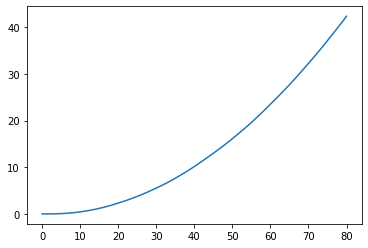

In [14]:
plt.plot(range(len(times)),times)
plt.savefig(time.strftime("%Y-%m-%d_%H:%M:%S")+'times.png', facecolor='w', transparent=False)

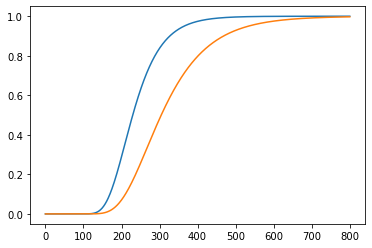

In [15]:
plt.plot(range(M),Pcurr)
# plt.plot(range(M),Rcurr)

# plt.plot(range(M),P[:,Q-1])
plt.plot(range(M),R[:,Q-1])
# plt.xlabel("m")
# plt.ylabel("P(m,"+str(Q)+")")
plt.savefig(time.strftime("%Y-%m-%d_%H:%M:%S")+'uniformVs.png', facecolor='w', transparent=False)

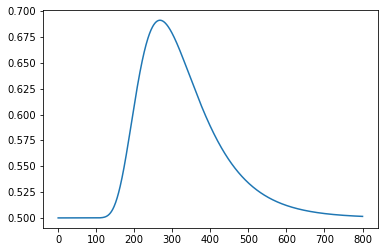

In [16]:
temp = 0.5*(1+Pcurr-R[:,Q-1])
plt.ymin=0.0
plt.ymax=1.0
plt.plot(range(len(Pcurr)),temp)
# plt.xlabel("m")
# plt.ylabel("Advantage")
plt.savefig(time.strftime("%Y-%m-%d_%H:%M:%S")+'-advantage.png', facecolor='w', transparent=False)